In [45]:
import pandas as pd
import os 
from src.files import XMLFile, FASTAFile
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
glob.glob('./')

In [2]:
genome_metadata_df = load_genome_metadata(refseq_only=True)

In [6]:
genome_ids = genome_metadata_df.sort_values('checkm_completeness').drop_duplicates('class').index
ncbi = NCBIDatasets()
ncbi.run(genome_ids)

NCBIDatasets.run: Downloading data for GCF_000300075.1.:   0%|          | 0/121 [00:00<?, ?it/s]

NCBIDatasets.run: Downloading data for GCF_015775515.1.: 100%|██████████| 121/121 [13:15<00:00,  6.58s/it]


In [13]:
glob.glob('./utils.py')

['./utils.py']

In [10]:
prodigal = Prodigal()
for input_path in glob.glob('../data/genomes/*'):
    prodigal.run(input_path)

In [32]:
os.listdir('../data/refseq')
ref = ReferenceGenome('../data/refseq/GCF_000024365.1_genomic.gbff', genome_id='GCF_000024365.1')

In [33]:
df = FASTAFile('../data/prodigal/GCF_000024365.1_protein.faa').to_df(prodigal_output=True)

results_df = ref.search(df)

ReferenceGenome.search: 100%|██████████| 5465/5465 [00:55<00:00, 98.54it/s] 


ReferenceGenome._merge: 141 entries in the query DataFrame had no valid hits in the reference.


In [32]:
ref_df = load_ref_output(genome_metadata_df=genome_metadata_df, feature='CDS')

In [33]:
# What fraction of the sequences align to a coding sequence?
ref_df = ref_df[~ref_df.ref_pseudo.astype(bool)]

In [35]:
def is_correct(row):
    return (row.stop == row.ref_stop) and (row.start == row.ref_start) 

def is_n_trunc(row):
    if row.strand == 1:
        return (row.start > row.ref_start)
    elif row.strand == -1:
        return (row.stop < row.ref_stop)

def is_c_trunc(row):
    if row.strand == 1:
        return (row.stop < row.ref_stop)
    elif row.strand == -1:
        return (row.start > row.ref_start)

def is_n_ext(row):
    if row.strand == 1:
        return (row.start < row.ref_start)
    elif row.strand == -1:
        return (row.stop > row.ref_stop)

def is_c_ext(row):
    if row.strand == 1:
        return (row.stop > row.ref_stop)
    elif row.strand == -1:
        return (row.start < row.ref_start)

ref_df['correct'] = ref_df.apply(is_correct, axis=1)
ref_df['c_trunc'] = ref_df.apply(is_c_trunc, axis=1)
ref_df['n_trunc'] = ref_df.apply(is_n_trunc, axis=1)
ref_df['n_ext'] = ref_df.apply(is_n_ext, axis=1)
ref_df['c_ext'] = ref_df.apply(is_c_ext, axis=1)

In [37]:
# Remove the pseudogene hits, at least for now. 
ref_df = ref_df[~ref_df.ref_pseudo.astype(bool)]

print('Total number of sequences:', len(ref_df))
print(f'{ref_df.correct.sum()} sequences are have exact alignments.')
print(f'{ref_df.n_trunc.sum()} sequences are truncated at the N-terminus.')
print(f'{ref_df.c_trunc.sum()} sequences are truncated at the C-terminus.')


Total number of sequences: 296845
254102 sequences are have exact alignments.
16803 sequences are truncated at the N-terminus.
2880 sequences are truncated at the C-terminus.


In [39]:
ref_df[ref_df.c_trunc][['ref_stop_codon', 'stop_codon', 'ref_product']]

,ref_stop_codon,stop_codon,ref_product
id,,,
NC_021487.1_1708,TAG,TGA,redoxin domain-containing protein
NZ_BBCC01000003.1_1,GAT,CGG,acyl-CoA dehydrogenase family protein
NZ_BBCC01000004.1_101,CCG,AGC,FAD-dependent oxidoreductase
NZ_BBCC01000019.1_48,GTG,GGT,hypothetical protein
NZ_BBCC01000020.1_1,GGC,CGG,FAD-dependent oxidoreductase
...,...,...,...
NZ_QQBG01000004.1_11,ATT,ACA,hypothetical protein
NZ_QQBG01000010.1_47,ATC,TAT,hypothetical protein
NZ_QQBG01000013.1_1,TCT,GTT,hypothetical protein


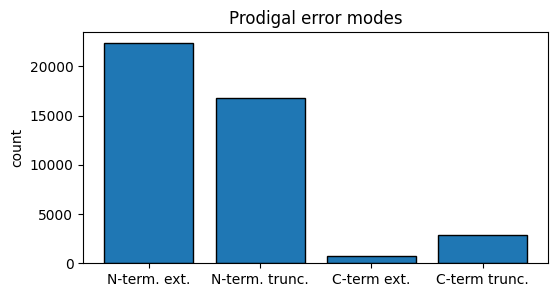

In [51]:
# Maybe plot some kind of confusion matrix thing showing the frequency of different boundary errors. 
# The current state of the reference genome search does not detect cases where there is both a truncation and extension. 

# row_labels = ['N-term. ext.', 'N-term. trunc.']
# col_labels = ['C-term ext.', 'C-term trunc.']

# matrix = np.zeros((2, 2))
# matrix[0][0] = (ref_df.n_ext & ref_df.c_ext).sum()
# matrix[0][1] = (ref_df.n_ext & ref_df.c_trunc).sum()
# matrix[1][0] = (ref_df.n_trunc & ref_df.c_ext).sum()
# matrix[1][1] = (ref_df.n_trunc & ref_df.c_trunc).sum()
# matrix = pd.DataFrame(matrix, index=row_labels, columns=col_labels)
# matrix = matrix.astype(int)

fig, ax = plt.subplots(figsize=(6, 3))

labels = ['N-term. ext.', 'N-term. trunc.', 'C-term ext.', 'C-term trunc.'] 
heights = [ref_df.n_ext.sum(), ref_df.n_trunc.sum(), ref_df.c_ext.sum(), ref_df.c_trunc.sum()]
ax.bar(np.arange(len(heights)), heights, edgecolor='black')
ax.set_title('Prodigal error modes')
ax.set_ylabel('count')
ax.set_xticks(np.arange(len(heights)), labels=labels)

plt.show()